In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Question 1

In [2]:
from pna.quad import composite_trapezium, guass_legendre, clenshaw_curtis

%psource composite_trapezium

def composite_trapezium(f, a, b, n):
    x = np.linspace(a, b, n)
    y = f(x)
    h = (b - a) / n
    return (h / 2) * (y[0] + 2 * np.sum(y[1:-1]) + y[-1])


In [3]:
%psource guass_legendre

def guass_legendre(f, a, b, n):
    gamma = 0.5 / np.sqrt(1 - (2 * np.arange(1, n + 1, dtype=float)) ** (-2))
    T = np.zeros((n + 1, n + 1))
    sub_diag = T.reshape(-1)[n :: n + 2]
    sub_diag[...] = gamma
    sup_diag = T.reshape(-1)[1 :: n + 2]
    sup_diag[...] = gamma
    eigenvalues, eigenvectors = np.linalg.eigh(T)
    w = 2 * eigenvectors[0, :] ** 2
    return 0.5 * (b - a) * w @ f(0.5 * (b - a) * eigenvalues + 0.5 * (a + b))


In [4]:
%psource clenshaw_curtis

def clenshaw_curtis(f, a, b, n):
    # Generate Chebyshev spaced points
    x = 0.5 * ((b - a) * np.cos(np.pi * np.arange(0, n + 1) / n) + (b + a))

    # Evaluate function at Chebyshev points
    fx = f(x) / (2 * n)

    # Compute weights
    g = np.real(np.fft.fft(np.concatenate([fx, fx[-2:0:-1]])))
    w = np.concatenate([[g[0]], g[1 : n - 1] + g[-1 : n + 1 : -1], [g[-1]]])

    # Compute integral of Chebyshev basis over [-1,1]
    I = np.zeros_like(w)
    # Only even terms are non-zero
    I[::2] = 2 / (1 - np.arange(0, n, 2) ** 2)

    return 0.5 * (b - a) * I @ w


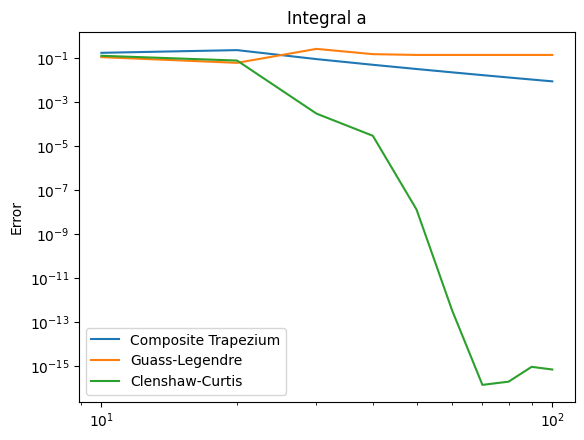

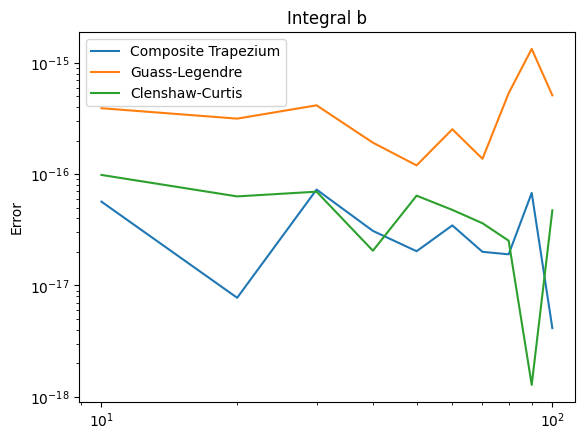

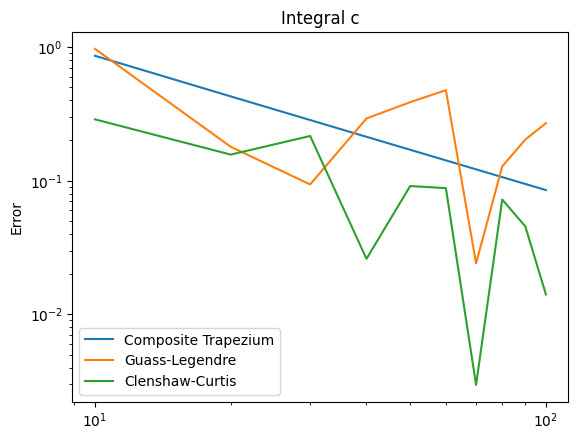

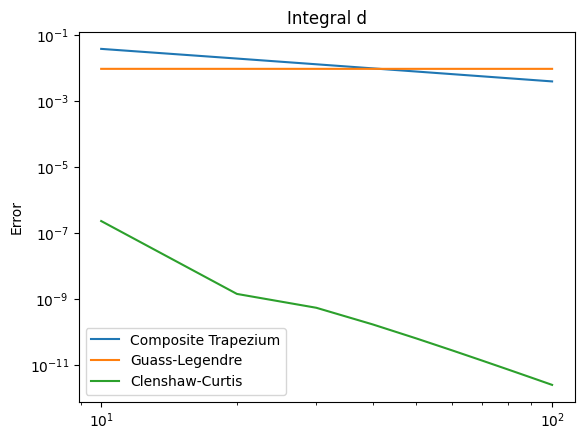

In [5]:
integrals = [
    (
        lambda x: 4 * np.pi * x * np.sin(20 * np.pi * x) * np.cos(2 * np.pi * x),
        (0, 1),
        -20 / 99,
    ),
    (lambda x: np.sin(2 * np.pi * x) * np.cos(4 * np.pi * x), (0, 1), 0),
    (
        lambda x: np.where(x < 1, x + 1, np.where((1 <= x) & (x <= 3), 3 - x, 2)),
        (0, 5),
        7.5,
    ),
    (lambda x: x ** (3 / 2), (0, 1), 0.4),
]

for i, (integrand, interval, exact) in enumerate(integrals):
    composite_trapezium_error = []
    guass_legendre_error = []
    clenshaw_curtis_error = []

    n = np.arange(10, 101, 10)
    for n_i in n:
        err = np.abs(composite_trapezium(integrand, *interval, n_i) - exact)
        composite_trapezium_error.append(err)

        err = np.abs(guass_legendre(integrand, *interval, n_i) - exact)
        guass_legendre_error.append(err)

        err = np.abs(clenshaw_curtis(integrand, *interval, n_i) - exact)
        clenshaw_curtis_error.append(err)

    fig, ax = plt.subplots()
    ax.loglog(n, composite_trapezium_error, label="Composite Trapezium")
    ax.loglog(n, guass_legendre_error, label="Guass-Legendre")
    ax.loglog(n, clenshaw_curtis_error, label="Clenshaw-Curtis")
    ax.set_label("n")
    ax.set_ylabel("Error")
    ax.set_title(f"Integral {chr(97+i)}")
    ax.legend()

For intergral A we see that Guass-Legendre and Clenshaw-Curtis converge much faster than the composite trapezium rule. For integral B, all methods converge to near machine precision for all $h$. This is because we are integrating over one period of the function so the integral is 0 and the errors committed cancel each other out. All the methods struggle with integral C, however, this is perhaps unsurprising given the discontinuity at $x=3$. This discontinuity will mean the underlying polynomial interpolant won't represent the function well. For intergral C again we see Guass-Legendre and Clenshaw-Curtis converge the fastest.

# Question 2

For this question, I have implemented my method based on the error bound for the trapezium rule given in the lecture

$$\left |I(f) - I_m(f) \right | \leq \sum_{k=1}^m \frac{(x_k - x_{k-1})^3}{12}\max_{x\in[x_{k-1}, x_k]}|f''(x_k)|$$.

However $\max_{x\in[x_{k-1}, x_k]}|f''(x_k)|$ is difficult to calulate so instead we approximate it by $|f''(\bar{x})|$ where $\bar{x}$ is the midpoint of $[x_{k-1}, x_k]$. Hopefully, for small intervals, this will be a good enough approximation. $f''$ is calculated using a second-order central difference.

If the sum on the right-hand side exceeds the user-supplied tolerance then the interval with the greatest contribution to the sum is divided into two. This process is repeated until the sum is less than the user-supplied tolerance and hence the error in approximating the integral is bounded by the supplied tolerance.

In [6]:
from pna.quad import adaptive_composite_trapezium, _second_order_central

%psource adaptive_composite_trapezium

def adaptive_composite_trapezium(f, a, b, n0, tol):
    x = np.linspace(a, b, n0)

    while True:
        # note it really should be max|f''| however here we just use f''(\bar{x})
        # where f'' is computed using a centred difference
        # if the intervals are small hopefully this isn't a terrible approximation
        error_summand = (
            np.diff(x) ** 3
            * np.abs(_second_order_central(f, (x[1:] + x[:-1]) / 2))
            / 12
        )
        err = np.sum(error_summand)
        if err < tol:
            break
        i = np.argmax(error_summand)
        x = np.insert(x, i + 1, 0.5 * (x[i] + x[i + 1]))

    h = np.diff(x)
    return np.sum(0.5 * h * (f(x[:-1]) + f(x[1:])))


In [7]:
%psource _second_order_central

def _second_order_central(f, x, h=np.finfo(float).eps ** (1 / 3)):
    return (f(x + h) - 2 * f(x) + f(x - h)) / h**2


In [8]:
integrand, interval, exact = integrals[0]

print(abs(adaptive_composite_trapezium(integrand, *interval, 1000, 1e-5) - exact))

3.1394007890539477e-07


Here we see the scheme has performed as expected as the error is bounded by the supplied tolerance. Further investigation is required to determine if better approximations of $\max_{x\in[x_{k-1}, x_k]}|f''(x_k)|$ would lead to a tighter error bound.

# Question 3

First we define functions for the four methods.

In [9]:
from pna.root import bisect, regula_falsi, illinois, newton_raphson

%psource bisect

def bisect(f, a, b, tol):
    count = 0
    f_c = math.inf
    while abs(f_c) > tol:
        count += 1
        c = 0.5 * (a + b)
        f_c = f(c)
        if f_c == 0:
            break
        elif f(a) * f(c) < 0:
            b = c
        else:
            a = c
    return c, count


In [10]:
%psource regula_falsi

def regula_falsi(f, a, b, tol):
    count = 0
    f_c = math.inf
    while abs(f_c) > tol:
        f_a = f(a)
        f_b = f(b)
        c = (a * f_b - b * f_a) / (f_b - f_a)
        f_c = f(c)
        count += 1
        if f_c == 0:
            break
        elif f_a * f_c < 0:
            b = c
        else:
            a = c
    return c, count


In [11]:
%psource illinois

def illinois(f, a, b, tol):
    count = 0
    right = True
    count = 0
    f_c = math.inf
    while abs(f_c) > tol:
        f_a = f(a)
        f_b = f(b)
        if count > 1:
            if right:
                f_b /= 2
            else:
                f_a /= 2
        c = (a * f_b - b * f_a) / (f_b - f_a)
        f_c = f(c)
        count += 1
        if f_c == 0:
            break
        elif f_a * f(c) < 0:
            b = c
            if right:
                right_count = 0
            else:
                count += 1
            right = False
        else:
            a = c
            if not right:
                count = 0
            else:
                count += 1
            right = True
    return c, count


In [12]:
%psource newton_raphson

def newton_raphson(f, f_prime, x0, tol):
    k = 0
    x = x0
    while abs(f(x)) > tol:
        x -= f(x) / f_prime(x)
        k += 1
    return x, k


The plot $f(x)$ over the interval $[0,4]$ to determine valid brackets of the roots.

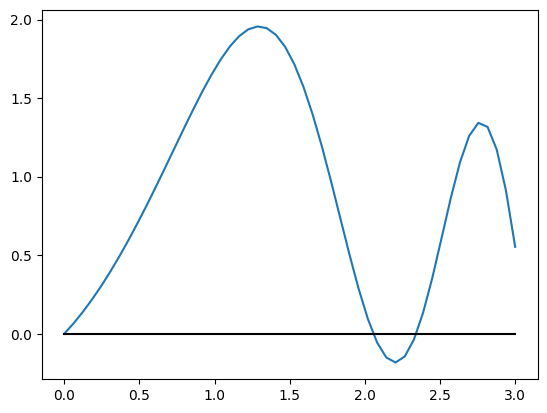

In [13]:
f = lambda x: np.sin(x) + np.sin(x**2)

x = np.linspace(0, 3)

fig, ax = plt.subplots()
ax.plot(x, f(x))
ax.plot([0, 3], [0, 0], "k")

We see that there are three roots bracketed by $[-0.25, 0.25]$, $[2, 2.2]$ and $[2.2, 2.5]$. Using this we can calculate the roots using each of the methods.

In [14]:
f_prime = lambda x: np.cos(x) + 2 * x * np.cos(x**2)

brackets = [(-0.25, 0.25), (1.8, 2.2), (2.2, 2.5)]
tol = 1e-9

for i, bracket in enumerate(brackets):
    print(f"\n\nRoot {i+1}, bracketed by {bracket}")

    x_star, iterations = bisect(f, *bracket, tol)
    print(f"Bisection: {x_star=}, {iterations=}")
    x_star, iterations = regula_falsi(f, *bracket, tol)
    print(f"Regula Falsi: {x_star=}, {iterations=}")
    x_star, iterations = illinois(f, *bracket, tol)
    print(f"Illinois: {x_star=}, {iterations=}")
    x_star, iterations = newton_raphson(f, f_prime, bracket[0], tol)
    print(f"Newton Raphson: {x_star=}, {iterations=}")



Root 1, bracketed by (-0.25, 0.25)
Bisection: x_star=0.0, iterations=1
Regula Falsi: x_star=-9.537843679676623e-10, iterations=12
Illinois: x_star=-4.727872667557848e-16, iterations=2
Newton Raphson: x_star=2.7033771063321343e-15, iterations=5


Root 2, bracketed by (1.8, 2.2)
Bisection: x_star=2.0560096457600587, iterations=28
Regula Falsi: x_star=2.0560096455363697, iterations=18
Illinois: x_star=2.0560096457619434, iterations=1
Newton Raphson: x_star=2.0560096452469483, iterations=4


Root 3, bracketed by (2.2, 2.5)
Bisection: x_star=2.3416277181357144, iterations=28
Regula Falsi: x_star=2.3416277183608094, iterations=17
Illinois: x_star=2.341627718511478, iterations=2
Newton Raphson: x_star=-4.216052223582135, iterations=4


Interestingly, we see for the final root our initial starting point for Newton Raphson didn't lead us to the correct root. This shows one of the limitations of Newton Raphson: you cannot guarantee you will converge to the root you were expecting.

To get a better idea of the convergence of each method we can choose one root and look at how many iterations are required to satisfy an increasingly stringent tolerance.

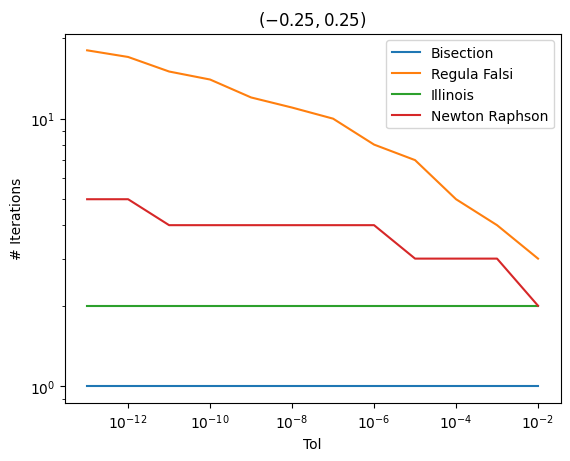

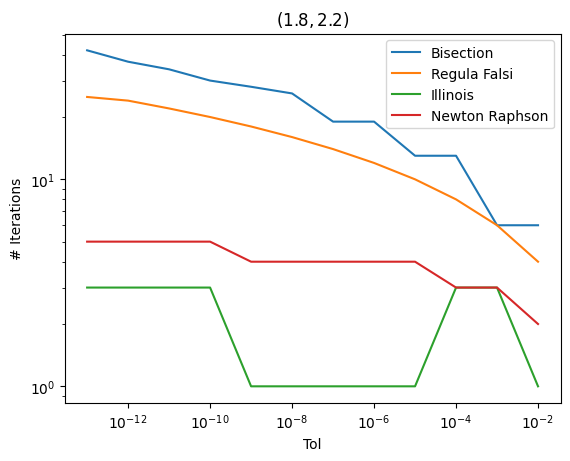

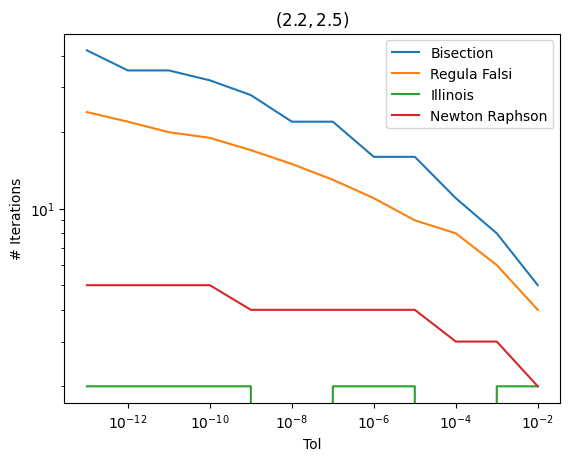

In [15]:
tols = np.logspace(-2, -13, 12)

for bracket in brackets:
    bisect_iter = []
    regula_falsi_iter = []
    illinois_iter = []
    newton_raphson_iter = []
    for tol in tols:
        bisect_iter.append(bisect(f, *bracket, tol)[1])
        regula_falsi_iter.append(regula_falsi(f, *bracket, tol)[1])
        illinois_iter.append(illinois(f, *bracket, tol)[1])
        newton_raphson_iter.append(newton_raphson(f, f_prime, bracket[1], tol)[1])

    fig, ax = plt.subplots()
    ax.loglog(tols, bisect_iter, label="Bisection")
    ax.loglog(tols, regula_falsi_iter, label="Regula Falsi")
    ax.loglog(tols, illinois_iter, label="Illinois")
    ax.loglog(tols, newton_raphson_iter, label="Newton Raphson")
    ax.legend()
    ax.set_xlabel("Tol")
    ax.set_ylabel("# Iterations")
    ax.set_title(f"${bracket}$")

In general, here we see that Illinois coverges fastest followed by Newton Raphson, Regula Falsi and Bisection. The exception is the first root $x=0$ where the provided bracket is symetrical about the root so the bisection method converges exactly in the first iteration.

# Question 4

Here we find the Newton fractal given by $z^3 - 1 = 0$. But first we need to know what the roots of the polynomial are so we know how to colour each point. We can do this by finding the eigenvalues of the companion matrix.

In [16]:
from pna.root import poly_roots

%psource poly_roots

def poly_roots(a):
    """Compute roots of polynomial. Coeffs should be given in order a_n to a_0"""
    n = len(a) - 1
    C = np.zeros((n, n))
    sub_diag = C.reshape(-1)[n :: n + 1]
    sub_diag[...] = 1
    C[:, -1] -= a[:-1] / a[-1]
    return np.linalg.eigvals(C)


Now we can compute the roots of the function we can compute the Newton fractal.

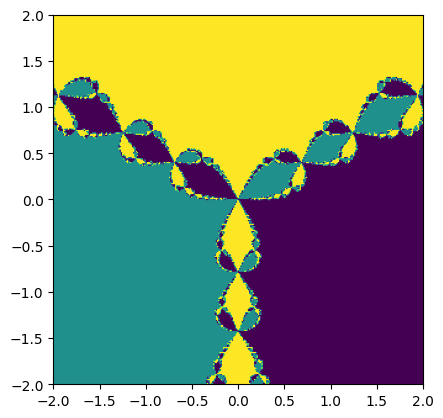

In [17]:
f = lambda z: z**3 - 1
f_prime = lambda z: 3 * z**2

x = np.linspace(-2, 2, 300)
y = np.linspace(-2, 2, 300)

im = np.zeros((len(x), len(y)))

roots = poly_roots(np.array([1, 0, 0, -1]))

for i, xi in enumerate(x):
    for j, yi in enumerate(y):
        root, _ = newton_raphson(f, f_prime, x0=complex(xi, yi), tol=1e-9)

        if np.isclose(root, roots[0]):
            im[i, j] = 1
        elif np.isclose(root, roots[1]):
            im[i, j] = 2
        elif np.isclose(root, roots[2]):
            im[i, j] = 3

fig, ax = plt.subplots()
ax.imshow(im, origin="lower", extent=[-2, 2, -2, 2])
ax.set_aspect("equal")

Sorry, this could certainly be made more exciting however I have other problem sheets to do!